#ML Course Regression Assignment: Predicting Housing Prices

## Dataset: Boston Housing Prices

In this assignment, you will explore a dataset of housing prices and use regression to predict house prices based on various features. You will also perform exploratory data analysis (EDA), visualize the data, and select important features.

### Instructions:
- Answer the following questions by writing code in the cells below.
- Be sure to visualize your findings and explain your reasoning.
- Finally, train a regression model to predict housing prices and evaluate its performance.

---

## **1. Data Loading and Exploration**

### Question 1: Load the dataset and inspect the first few rows.
- Load the Boston housing dataset (from `sklearn.datasets`) into a pandas DataFrame.
Since the **Boston Housing dataset** is deprecated, you can download the alternative housing dataset from [Kaggle Housing Prices Dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) if necessary.

- Display the first 5 rows to understand the structure of the data.



In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [26]:
df = pd.read_csv('Misc/train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Question 2: Check for missing values.
- Identify if there are any missing values in the dataset. How would you handle them if any exist?


In [27]:
print(df.shape)

(1460, 81)


In [ ]:
cols_null_count = df.isnull().sum()                     # Count null values in each column
cols_with_nulls = cols_null_count[cols_null_count > 0]  # Filter columns with null values
print(cols_with_nulls)

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


In [ ]:
cols_with_nulls_names = cols_with_nulls.index.tolist()              # list of columns with nulls
df[cols_with_nulls_names].select_dtypes(include=['number']).info()  # only numeric columns info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LotFrontage  1201 non-null   float64
 1   MasVnrArea   1452 non-null   float64
 2   GarageYrBlt  1379 non-null   float64
dtypes: float64(3)
memory usage: 34.3 KB


count    1460.000000
mean       69.863699
std        22.027677
min        21.000000
25%        60.000000
50%        69.000000
75%        79.000000
max       313.000000
Name: LotFrontage, dtype: float64


<Axes: xlabel='LotFrontage', ylabel='Count'>

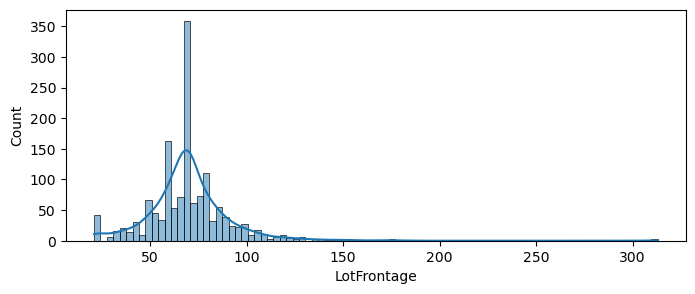

In [ ]:
# Explore the LotFrontage feature (Linear feet of street connected to property)
print(df['LotFrontage'].describe())

plt.figure(figsize=(8, 3))
sns.histplot(df['LotFrontage'].dropna(), kde=True)

In [ ]:
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())    # fill nulls with median
df['LotFrontage'].isnull().sum()                                            # check if nulls are filled

0


---

## **2. Exploratory Data Analysis (EDA)**

### Question 3: Describe the dataset's numerical features.
- Use `describe()` to get a summary of the dataset's numerical columns.
- Which feature(s) have the highest and lowest values? Are there any surprising observations?

### Question 4: Visualize the distribution of house prices.
- Create a histogram of the house prices. Is the distribution normal or skewed?

### Question 5: Explore relationships between features and house prices.
- Create scatter plots for at least 3 features vs. house prices (target variable).
- What relationships do you observe between the selected features and the target?

---

## **3. Feature Selection**

### Question 6: Correlation Analysis
- Calculate the correlation matrix of the dataset.
- Based on the correlation, identify at least 2 features that are highly correlated with house prices.
- Are there any features that are strongly correlated with each other but not with the target?

---

## **4. Regression Modeling**

### Question 7: Split the dataset
- Split the dataset into training and testing sets. Use an 80/20 split.
- Make sure to separate the target variable (house prices) from the features.

### Question 8: Train a Linear Regression Model
- Train a Linear Regression model using the training data.
- Evaluate the model's performance on the test data by calculating the Mean Squared Error (MSE).

### Question 9: Feature Importance (Optional)
- If using a model like Ridge or Lasso, identify which features are most important in predicting house prices.

---

## **5. Conclusion**
- Summarize your findings and observations.
- Reflect on the regression model's performance and whether there are any improvements you would recommend.